# Initial Analysis Result

|   About the script    |                                         |
| ----------- | --------------------------------------- |
| Last update |  Nov 23 2019  add comment|
| Experiment  | AZ one; NGA IL; Vote.org (Hustle)|



|    Available covariates   |      |
| ----------- | --------------------------------------- |
| Vote Propensity| computed based on available covariates|
|Experiemnt indicator| indicates the data from which experiemnt|

## Load library and datasets

In [1]:
# load libraries

# data cleaning and reshape
import pandas as pd
import numpy as np

# caculate standard error
from scipy.stats import sem

# regression
import statsmodels.api as sm
# regression use formualar
import statsmodels.formula.api as smf
# regression with clustered standard error
import econtools.metrics as mt

# plot display
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# supress warning inline
import warnings
warnings.filterwarnings('ignore')

# display and export regression table
from stargazer.stargazer import Stargazer
# display latex and html table
from IPython.display import Latex
from IPython.display import HTML

In [2]:
# set random seed to ensure the following code and result is replicable
np.random.seed(2019)

### Read data

In [3]:
# One Arizona 
AZ = pd.read_csv('../../Machine Learing HTE/1_data/az_one/AZ_one_with_ITEs.csv')

In [7]:
# NextGen
IL = pd.read_csv('../../Machine Learing HTE/1_data/nga_il/NGA_IL_with_ITEs.csv')

In [8]:
# Vote.org
Hustle = pd.read_csv('../../Machine Learing HTE/1_data/org_hustle/org_hustle_with_ITEs.csv')

In [9]:
AZ['experiment'] = 'AZ_One'

In [10]:
IL['experiment'] = 'NGA_IL'

In [11]:
Hustle['experiment'] = 'org_hustle'

In [12]:
IL.head()

,Propensity,ITE,Treatment,Turnout,hh_id,Propensity Range,Propensity_square,experiment
0,0.160607,-0.002783,1,0,61153.0,"(0.1, 0.2]",0.025795,NGA_IL
1,0.077664,0.012406,1,0,160473.0,"(0.0, 0.1]",0.006032,NGA_IL
2,1.000000,-0.474798,1,0,137591.0,"(0.9, 1.0]",1.000000,NGA_IL
3,0.138696,0.004291,0,1,11275.0,"(0.1, 0.2]",0.019237,NGA_IL
4,0.282955,-0.009993,1,0,52014.0,"(0.2, 0.3]",0.080064,NGA_IL


In [13]:
AZ.head()

,Propensity,ITE,Treatment,Turnout,hh_id,Propensity_square,Propensity Range,experiment
0,0.836493,0.009200,1,0,24321,0.699721,"(0.8, 0.9]",AZ_One
1,0.549410,0.005665,1,0,54491,0.301851,"(0.5, 0.6]",AZ_One
2,0.659421,0.004999,1,0,167763,0.434837,"(0.6, 0.7]",AZ_One
3,0.549410,0.005665,1,0,233259,0.301851,"(0.5, 0.6]",AZ_One
4,0.549410,0.005665,0,1,2300,0.301851,"(0.5, 0.6]",AZ_One


In [14]:
df = pd.concat([AZ, IL, Hustle])

### check data set

In [15]:
# non-compliance and attrition in One Arizona and NextGen
pd.crosstab(index = df.experiment,
           columns = [df.Treatment])

Treatment,0,1
experiment,,
AZ_One,41113,185885
NGA_IL,94229,94257
org_hustle,301920,905396


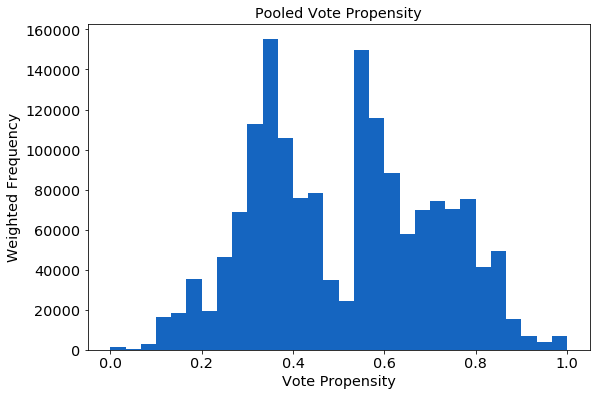

In [17]:
# distribution of propensity score for pooled dataset

import matplotlib.pylab as pylab
params = {
        'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(9,6))
ax = plt.hist(df.Propensity, 
         30,color='#1565c0')
plt.xlabel("Vote Propensity")
plt.ylabel("Weighted Frequency")
plt.title("Pooled Vote Propensity") # You can comment this line out if you don't need title
plt.show(ax)

In [19]:
df['vp_10']=pd.cut(df['Propensity'], np.arange(0,1.1,0.1))

## Vote Turnout and  Vote Propensity Crosstabs

In [20]:
exp_dummy = pd.get_dummies(df.experiment).drop(columns=['AZ_One'])

In [21]:
df = pd.concat([df,exp_dummy ], axis=1)

In [22]:
df.shape

(1622800, 11)

### Overall

In [23]:
def get_bins_overall():
    pd.options.display.float_format = '{:.3%}'.format
    a = df.loc[:, ['vp_10','Turnout','Treatment']].\
    groupby(['vp_10',"Treatment"]). \
    Turnout.agg([('Size','count'),
              ('Turnout',np.mean)]).reset_index()
    
    b = df.loc[:, ['vp_10','Turnout','Treatment']].\
    groupby(['vp_10',"Treatment"]). \
    Turnout.agg([('Size','count'),
              ('Turnout',np.mean)]).reset_index().groupby('vp_10').Turnout.agg([('Effect','diff')])
    
    r = pd.concat([a,b], axis=1)
    r.rename( columns={'vp_10': 'Vote Propensity Range'}, inplace = True)
    r.Effect.fillna(" ", inplace=True)
    r.Treatment.replace([0,1],['Control', 'Treatment'], inplace=True)
    return r

In [24]:
HTML(get_bins_overall().to_html(index=False))

Vote Propensity Range,Treatment,Size,Turnout,Effect
"(0.0, 0.1]",Control,2230,5.740%,
"(0.0, 0.1]",Treatment,2617,25.029%,19.289%
"(0.1, 0.2]",Control,33514,15.656%,
"(0.1, 0.2]",Treatment,36480,16.760%,1.104%
"(0.2, 0.3]",Control,46122,27.278%,
"(0.2, 0.3]",Treatment,88455,28.663%,1.386%
"(0.3, 0.4]",Control,99261,34.129%,
"(0.3, 0.4]",Treatment,274455,34.322%,0.193%
"(0.4, 0.5]",Control,49424,44.770%,
"(0.4, 0.5]",Treatment,140045,45.166%,0.396%


### By Experiment

In [25]:
def get_bins_table(exp):
    pd.options.display.float_format = '{:.3%}'.format
    a = df.loc[df.experiment==exp, ['vp_10','Turnout','Treatment']].\
    groupby(['vp_10',"Treatment"]). \
    Turnout.agg([('Size','count'),
              ('Turnout',np.mean)]).reset_index()
    
    b = df.loc[df.experiment==exp, ['vp_10','Turnout','Treatment']].\
    groupby(['vp_10',"Treatment"]). \
    Turnout.agg([('Size','count'),
              ('Turnout',np.mean)]).reset_index().groupby('vp_10').Turnout.agg([('Effect','diff')])
    
    r = pd.concat([a,b], axis=1)
    r.rename( columns={'vp_10': 'Vote Propensity Range'}, inplace = True)
    r.Effect.fillna(" ", inplace=True)
    r.Treatment.replace([0,1],['Control', 'Treatment'], inplace=True)
    return r
  

#### Arizona One

In [26]:
HTML(get_bins_table('AZ_One').to_html(index=False))

Vote Propensity Range,Treatment,Size,Turnout,Effect
"(0.0, 0.1]",Control,61,1.639%,
"(0.0, 0.1]",Treatment,458,75.764%,74.125%
"(0.1, 0.2]",Control,27,18.519%,
"(0.1, 0.2]",Treatment,221,66.516%,47.997%
"(0.2, 0.3]",Control,64,18.750%,
"(0.2, 0.3]",Treatment,293,57.679%,38.929%
"(0.3, 0.4]",Control,95,28.421%,
"(0.3, 0.4]",Treatment,430,65.116%,36.695%
"(0.4, 0.5]",Control,495,42.424%,
"(0.4, 0.5]",Treatment,2173,47.676%,5.252%


#### NextGen

In [27]:
HTML(get_bins_table('NGA_IL').to_html(index=False))

Vote Propensity Range,Treatment,Size,Turnout,Effect
"(0.0, 0.1]",Control,2169,5.855%,
"(0.0, 0.1]",Treatment,2159,14.266%,8.411%
"(0.1, 0.2]",Control,32120,15.342%,
"(0.1, 0.2]",Treatment,32202,15.844%,0.501%
"(0.2, 0.3]",Control,24712,25.186%,
"(0.2, 0.3]",Treatment,24618,25.416%,0.230%
"(0.3, 0.4]",Control,11364,34.468%,
"(0.3, 0.4]",Treatment,11439,34.959%,0.491%
"(0.4, 0.5]",Control,4748,45.451%,
"(0.4, 0.5]",Treatment,4690,43.710%,-1.741%


#### Vote.org

In [28]:
HTML(get_bins_table('org_hustle').to_html(index=False))

Vote Propensity Range,Treatment,Size,Turnout,Effect
"(0.1, 0.2]",Control,1367,22.970%,
"(0.1, 0.2]",Treatment,4057,21.321%,-1.649%
"(0.2, 0.3]",Control,21346,29.725%,
"(0.2, 0.3]",Treatment,63544,29.787%,0.063%
"(0.3, 0.4]",Control,87802,34.091%,
"(0.3, 0.4]",Treatment,262586,34.244%,0.153%
"(0.4, 0.5]",Control,44181,44.723%,
"(0.4, 0.5]",Treatment,133182,45.177%,0.454%
"(0.5, 0.6]",Control,36277,56.341%,
"(0.5, 0.6]",Treatment,108994,56.530%,0.188%


## Heterogeneous Treatment Effect by OLS

### Pooled regression

In [29]:
df.head()

,ITE,Propensity,Propensity Range,Propensity_square,Treatment,Turnout,experiment,hh_id,vp_10,NGA_IL,org_hustle
0,0.920%,83.649%,"(0.8, 0.9]",69.972%,1,0,AZ_One,24321,"(0.8, 0.9]",0,0
1,0.567%,54.941%,"(0.5, 0.6]",30.185%,1,0,AZ_One,54491,"(0.5, 0.6]",0,0
2,0.500%,65.942%,"(0.6, 0.7]",43.484%,1,0,AZ_One,167763,"(0.6, 0.7]",0,0
3,0.567%,54.941%,"(0.5, 0.6]",30.185%,1,0,AZ_One,233259,"(0.5, 0.6]",0,0
4,0.567%,54.941%,"(0.5, 0.6]",30.185%,0,1,AZ_One,2300,"(0.5, 0.6]",0,0


In [30]:
 def get_experiment_pool():
    return smf.ols('Turnout ~ \
    Treatment + Propensity + Treatment * Propensity',data=df).\
    fit()

In [31]:
 def get_experiment_reg(exp):
    return smf.ols('Turnout ~ \
    Treatment + Propensity + Treatment * Propensity',data=df[df.experiment==exp]).\
    fit()

In [32]:
pool = get_experiment_pool()

In [33]:
az = get_experiment_reg('AZ_One')

In [34]:
il = get_experiment_reg('NGA_IL')

In [35]:
hu=get_experiment_reg('org_hustle')

In [36]:
stargazer = Stargazer([pool,az,il, hu])
stargazer.significant_digits(4)
stargazer.title('Treatment by Experiment')
stargazer.custom_columns(['Pooled','One Arizona', 'NextGen Climate','Vote.org'], [1,1,1,1])

In [38]:
Latex(stargazer.render_latex())

<IPython.core.display.Latex object>

In [37]:
HTML(stargazer.render_html())

# X-learner to Compute Individual Treatment Effect (ITE)

In [39]:
# Outcome: Voter Turn out in 2016
Y = np.array(df['Turnout'].astype(int))
# Treatment: Text Messaging
T = np.array(df['Treatment'].astype(int)) 
# Covariates
X =np.array(df[['Propensity','NGA_IL','org_hustle']])
# Meta Learner Library
from econml.metalearners import TLearner, SLearner, XLearner
# Base Algorithm Library
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,GradientBoostingRegressor 
n=X.shape[0]
import matplotlib.pyplot as plt

In [40]:
# Instantiate X learner
controls_model = GradientBoostingRegressor(n_estimators=100, 
                                           max_depth=6, 
                                           min_samples_leaf=int(n/1000))

treated_model = GradientBoostingRegressor(n_estimators=100, 
                                          max_depth=6, 
                                          min_samples_leaf=int(n/1000))

propensity_model = RandomForestClassifier(n_estimators=100, 
                                          max_depth=6, 
                                        min_samples_leaf=int(n/1000),
                                        class_weight='balanced_subsample')

X_learner = XLearner(controls_model=controls_model, 
                     treated_model=treated_model, 
                     propensity_model=propensity_model)
# Train X_learner
X_learner.fit(Y, T, X)
# Estimate treatment effects on test data
X_te = X_learner.effect(X)

# Visulization: vote propensity vs. estimated ITE

## T-learner

In [41]:
learner_df =pd.DataFrame({'Vote Propensity': X[:, 0],
                          'experiment': df.experiment,
                          'Estimated ITE':X_te,
                         'Treatment':T,
                         'Turnout': Y})

In [42]:
learner_df.shape

(1622800, 5)

In [43]:
learner_df.to_csv('../../Machine Learing HTE/1_data/pooled.csv')

In [21]:
learner_df = pd.read_csv('../../Machine Learing HTE/1_data/pooled.csv')

In [22]:
learner_df2 = pd.read_csv('../../Machine Learing HTE/1_data/pooled.csv')

In [23]:
learner_df2.experiment = 'all'

In [27]:
plot_df = pd.concat([learner_df, learner_df2 ], ignore_index=True)

In [30]:
plot_df.experiment.unique()

array(['AZ_One', 'NGA_IL', 'org_hustle', 'all'], dtype=object)

In [33]:
learner_df.head()

,Unnamed: 0,Vote Propensity,experiment,Estimated ITE,Treatment,Turnout
0,0,0.836493,AZ_One,0.004259,1,0
1,1,0.549410,AZ_One,0.005391,1,0
2,2,0.659421,AZ_One,0.005362,1,0
3,3,0.549410,AZ_One,0.005391,1,0
4,4,0.549410,AZ_One,0.005391,0,1


In [ ]:
y = learner_df['ITE']

X = learner_df[['Propensity']]
X = sm.add_constant(X)

ols = sm.OLS(y, X)

In [36]:
 def est_experiment_pool():
    y = learner_df['Estimated ITE']

    X = learner_df[['Vote Propensity']]
    X = sm.add_constant(X)

    return sm.OLS(y, X).fit()

 def est_experiment_reg(exp):
    y = learner_df[learner_df.experiment==exp]['Estimated ITE']

    X = learner_df[learner_df.experiment==exp][['Vote Propensity']]
    X = sm.add_constant(X)

    return sm.OLS(y, X).fit()

In [38]:
HTML(stargazer.render_html())

In [37]:



pool = est_experiment_pool()

az = est_experiment_reg('AZ_One')

il = est_experiment_reg('NGA_IL')

hu=est_experiment_reg('org_hustle')

stargazer = Stargazer([pool,az,il, hu])
stargazer.significant_digits(4)
stargazer.title('Treatment by Experiment')
stargazer.custom_columns(['Pooled','One Arizona', 'NextGen Climate','Vote.org'], [1,1,1,1])

Latex(stargazer.render_latex())

<IPython.core.display.Latex object>

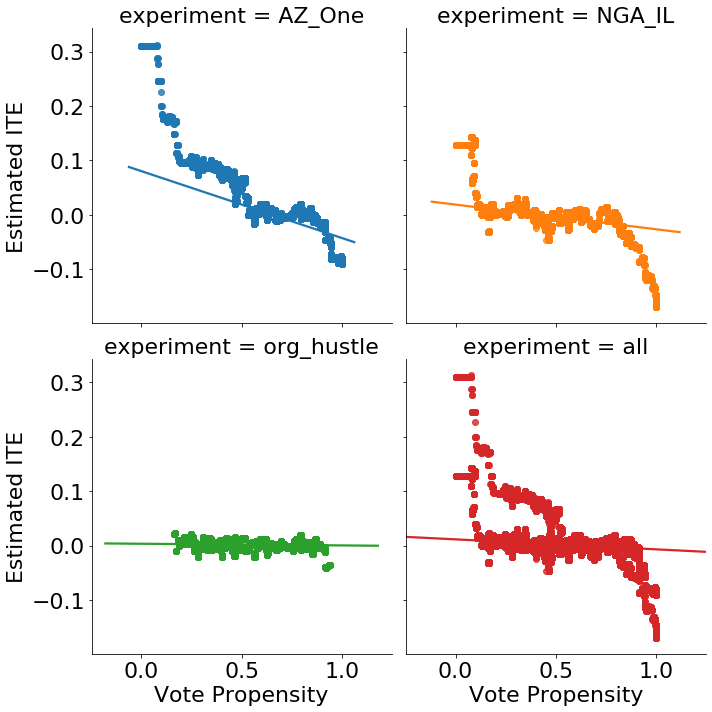

In [32]:
sns.lmplot(x='Vote Propensity', y='Estimated ITE',
     col="experiment", hue="experiment",  
                 data=plot_df,  col_wrap=2, height=5)
plt.tight_layout()
plt.savefig('ITE X-learner each',dpi=400)

In [9]:
import matplotlib.pylab as pylab
params = {
        'axes.labelsize': '22',
         'axes.titlesize':'22',
         'xtick.labelsize':'22',
         'ytick.labelsize':'22'}
pylab.rcParams.update(params)

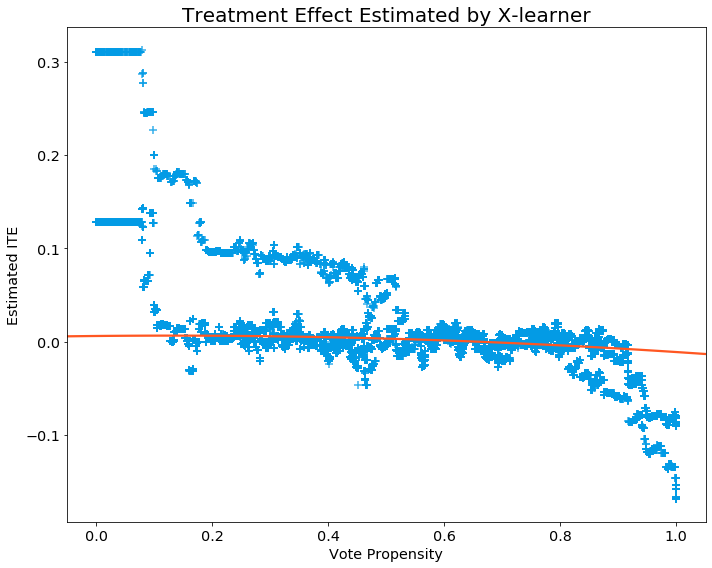

In [47]:
plt.figure(figsize=(10, 8))
ax = sns.regplot(x='Vote Propensity', y='Estimated ITE',
                 data=learner_df, 
                 order=2,
                 ci=100, 
                 marker="+",
                 scatter_kws={'color':'#039be5',"s": 50}, 
                 line_kws={'color':'#FF5722'})

plt.title('Treatment Effect Estimated by X-learner',
          {'fontsize': 20,
        'fontweight' : 5})
plt.tight_layout()
plt.savefig('ITE by Propensity with Parabola', dpi=800)

In [36]:
! jupyter nbconvert --to latex --template hidecode pool.ipynb

[NbConvertApp] Converting notebook pool.ipynb to latex
[NbConvertApp] Support files will be in pool_files/
[NbConvertApp] Making directory pool_files
[NbConvertApp] Making directory pool_files
[NbConvertApp] Making directory pool_files
[NbConvertApp] Making directory pool_files
[NbConvertApp] Making directory pool_files
[NbConvertApp] Writing 32046 bytes to pool.tex
